# Imports

In [17]:
# Linear Algebra, Plotting
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data Loading, Computer Vision Libraries
import os
import glob
import cv2 # pip install opencv-python-headless
from PIL import Image

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# PyTorch Deep Learning Imports
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# Import Images

input_size = 64 # Resize to 64x64
yes = []
no = []

for gl in glob.iglob('./Data/yes/*'):
    image = cv2.imread(gl)
    image=Image.fromarray(image,'RGB')
    image=image.resize((input_size, input_size))
    yes.append((image, 1))
for gl in glob.iglob('./Data/no/*'):
    image = cv2.imread(gl)
    image=Image.fromarray(image,'RGB')
    image=image.resize((input_size, input_size))
    no.append((image, 0))

data = yes + no

The "1" label is for a tumor present, and "0" is for when a tumor is not present

# Preprocessing

Let's view the first few images for tumor and no tumor.

In [3]:
def display_images(data, label_to_view, num_images=5):
    filtered_data = [item for item in data if item[1] == label_to_view]
    filtered_data = filtered_data[:num_images]
    
    fig, axes = plt.subplots(1, len(filtered_data), figsize=(15, 5)) 
    
    for ax, (image, label) in zip(axes, filtered_data):
        ax.imshow(image)
        ax.set_title(f"Label: {label}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

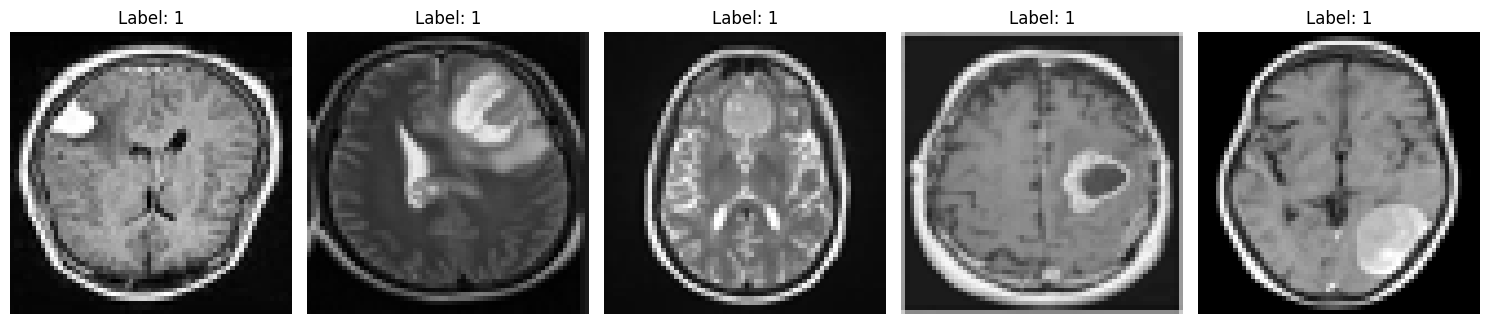

In [4]:
display_images(data, label_to_view=1, num_images=5) 

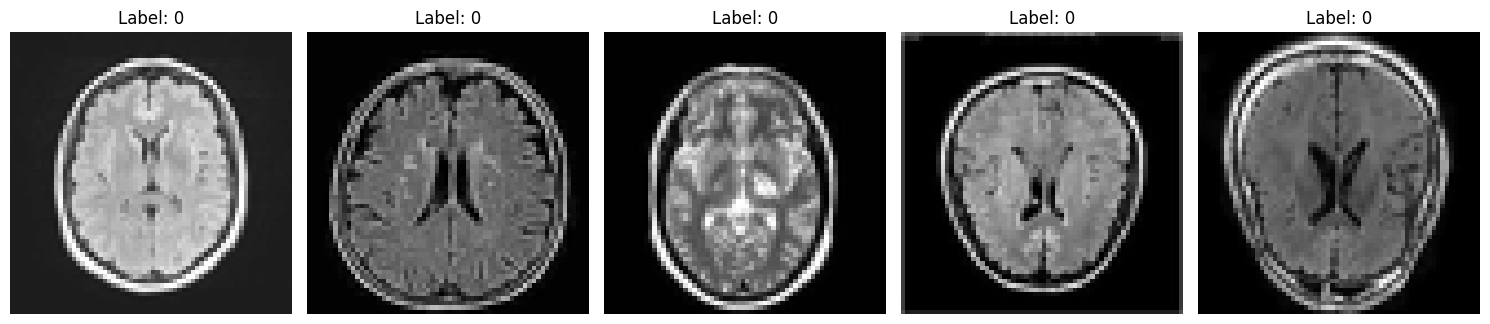

In [5]:
display_images(data, label_to_view=0, num_images=5) 

Let us convert these into numpy arrays of size 64x64 for modelling purposes

In [6]:
images = np.array([np.array(i[0]) for i in data])  
labels = np.array([i[1] for i in data])

print(images.shape)
print(labels.shape)

(3000, 64, 64, 3)
(3000,)


Let us split this into training, testing, and validation sets. For this split, we will use a train-test-val split ratio of 70-15-15. We will also stratify by the 'y' labels to ensure an even split amongst our classes

In [7]:
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, stratify=labels, shuffle=True, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, shuffle=True, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape} \n")

print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape} \n")

print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")

X_train shape: (2100, 64, 64, 3)
y_train shape: (2100,) 

X_test shape: (450, 64, 64, 3)
y_test shape: (450,) 

X_val shape: (450, 64, 64, 3)
y_val shape: (450,)


Count the number of different labels in each set to ensure that they are split evenly

In [8]:
train_label_counts = np.bincount(y_train)
print(f"Training set: {train_label_counts[0]} 0s, {train_label_counts[1]} 1s")

val_label_counts = np.bincount(y_val)
print(f"Validation set: {val_label_counts[0]} 0s, {val_label_counts[1]} 1s")

test_label_counts = np.bincount(y_test)
print(f"Test set: {test_label_counts[0]} 0s, {test_label_counts[1]} 1s")

Training set: 1050 0s, 1050 1s
Validation set: 225 0s, 225 1s
Test set: 225 0s, 225 1s


As a quick sanity check, let us view our images again to see if we split it correctly by label

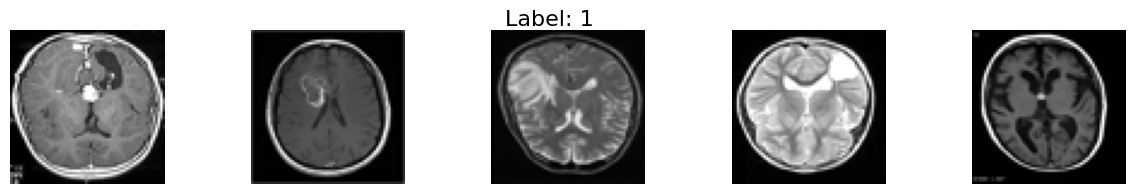

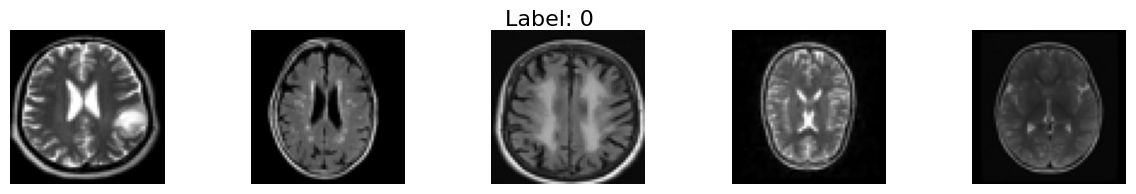

In [9]:
label_0_images = [X_train[i] for i in range(len(y_train)) if y_train[i] == 0]
label_1_images = [X_train[i] for i in range(len(y_train)) if y_train[i] == 1]

def display_images_by_label(images, label, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 2))
    fig.suptitle(f"Label: {label}", fontsize=16)
    for i, ax in enumerate(axes):
        if i < len(images):
            ax.imshow(images[i])
            ax.axis('off')
    plt.show()

display_images_by_label(label_1_images, label=1, num_images=5)
display_images_by_label(label_0_images, label=0, num_images=5)

## Tensor conversion (Only for CNN and MAE)

In [10]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)  # (N, C, H, W)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Convert to float and add dimension
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).permute(0, 3, 1, 2)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# PCA Reconstruction Classification

# Supervised Convolutional Neural Network (CNN) Classification

## Put the data into tensors and define our CNN

In [11]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.normalize = nn.BatchNorm2d(3)  
        self.conv = nn.Conv2d(3, 32, kernel_size=3, padding='same')  
        self.pool = nn.MaxPool2d(2) 
        self.flatten = nn.Flatten() 
        self.fc = nn.Linear(32 * (input_size // 2) * (input_size // 2), 1) 
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation for binary classification

    def forward(self, x):
        x = self.normalize(x)
        x = torch.relu(self.conv(x))
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

## Train our CNN

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 50
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")
    for inputs, labels in train_loader_tqdm:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)  
        loss = criterion(outputs, labels)  

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        predicted = (outputs > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        train_loader_tqdm.set_postfix({"Loss": f"{running_loss / len(train_loader):.4f}"})

    train_losses.append(running_loss / len(train_loader))  
    train_accuracies.append(100 * correct_train / total_train)  

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    val_loader_tqdm = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]", leave=False)
    with torch.no_grad():
        for inputs, labels in val_loader_tqdm:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            predicted = (outputs > 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(val_loader)) 
    val_accuracies.append(100 * correct_val / total_val) 

    print(f"Epoch {epoch+1}/{epochs}, "
          f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%, "
          f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.2f}%")

Epoch 1/50 [Train]: 100%|██████████| 66/66 [00:01<00:00, 41.72it/s, Loss=0.4782]


Epoch 1/50, Train Loss: 0.4782, Train Accuracy: 77.38%, Val Loss: 0.3879, Val Accuracy: 82.67%


Epoch 2/50 [Train]: 100%|██████████| 66/66 [00:01<00:00, 43.08it/s, Loss=0.3700]


Epoch 2/50, Train Loss: 0.3700, Train Accuracy: 83.05%, Val Loss: 0.3306, Val Accuracy: 86.00%


Epoch 3/50 [Train]: 100%|██████████| 66/66 [00:01<00:00, 42.68it/s, Loss=0.3080]


Epoch 3/50, Train Loss: 0.3080, Train Accuracy: 87.81%, Val Loss: 0.2916, Val Accuracy: 87.56%


Epoch 4/50 [Train]: 100%|██████████| 66/66 [00:01<00:00, 42.57it/s, Loss=0.2742]


Epoch 4/50, Train Loss: 0.2742, Train Accuracy: 89.00%, Val Loss: 0.2640, Val Accuracy: 89.11%


Epoch 5/50 [Train]: 100%|██████████| 66/66 [00:01<00:00, 43.54it/s, Loss=0.2339]


Epoch 5/50, Train Loss: 0.2339, Train Accuracy: 92.43%, Val Loss: 0.2448, Val Accuracy: 90.89%


Epoch 6/50 [Train]: 100%|██████████| 66/66 [00:01<00:00, 43.26it/s, Loss=0.2071]


Epoch 6/50, Train Loss: 0.2071, Train Accuracy: 93.43%, Val Loss: 0.2569, Val Accuracy: 90.44%


Epoch 7/50 [Train]: 100%|██████████| 66/66 [00:01<00:00, 41.46it/s, Loss=0.1914]


Epoch 7/50, Train Loss: 0.1914, Train Accuracy: 94.14%, Val Loss: 0.1996, Val Accuracy: 92.89%


Epoch 8/50 [Train]: 100%|██████████| 66/66 [00:01<00:00, 43.81it/s, Loss=0.1594]


Epoch 8/50, Train Loss: 0.1594, Train Accuracy: 95.95%, Val Loss: 0.1901, Val Accuracy: 93.56%


Epoch 9/50 [Train]: 100%|██████████| 66/66 [00:01<00:00, 43.29it/s, Loss=0.1446]


Epoch 9/50, Train Loss: 0.1446, Train Accuracy: 96.76%, Val Loss: 0.1706, Val Accuracy: 94.89%


Epoch 10/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 43.33it/s, Loss=0.1282]


Epoch 10/50, Train Loss: 0.1282, Train Accuracy: 97.10%, Val Loss: 0.1627, Val Accuracy: 95.33%


Epoch 11/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 42.39it/s, Loss=0.1169]


Epoch 11/50, Train Loss: 0.1169, Train Accuracy: 97.86%, Val Loss: 0.1564, Val Accuracy: 95.56%


Epoch 12/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 43.35it/s, Loss=0.1049]


Epoch 12/50, Train Loss: 0.1049, Train Accuracy: 98.00%, Val Loss: 0.1597, Val Accuracy: 94.89%


Epoch 13/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 43.10it/s, Loss=0.1005]


Epoch 13/50, Train Loss: 0.1005, Train Accuracy: 97.90%, Val Loss: 0.1294, Val Accuracy: 96.22%


Epoch 14/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 42.90it/s, Loss=0.0865]


Epoch 14/50, Train Loss: 0.0865, Train Accuracy: 98.62%, Val Loss: 0.1229, Val Accuracy: 96.89%


Epoch 15/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 41.95it/s, Loss=0.0768]


Epoch 15/50, Train Loss: 0.0768, Train Accuracy: 98.71%, Val Loss: 0.1136, Val Accuracy: 96.89%


Epoch 16/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 43.37it/s, Loss=0.0721]


Epoch 16/50, Train Loss: 0.0721, Train Accuracy: 99.05%, Val Loss: 0.1165, Val Accuracy: 97.11%


Epoch 17/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 44.64it/s, Loss=0.0682]


Epoch 17/50, Train Loss: 0.0682, Train Accuracy: 98.90%, Val Loss: 0.1073, Val Accuracy: 96.67%


Epoch 18/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 44.52it/s, Loss=0.0588]


Epoch 18/50, Train Loss: 0.0588, Train Accuracy: 99.10%, Val Loss: 0.1125, Val Accuracy: 96.44%


Epoch 19/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 41.38it/s, Loss=0.0552]


Epoch 19/50, Train Loss: 0.0552, Train Accuracy: 99.29%, Val Loss: 0.0981, Val Accuracy: 97.11%


Epoch 20/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 44.10it/s, Loss=0.0503]


Epoch 20/50, Train Loss: 0.0503, Train Accuracy: 99.38%, Val Loss: 0.0923, Val Accuracy: 97.11%


Epoch 21/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 43.56it/s, Loss=0.0473]


Epoch 21/50, Train Loss: 0.0473, Train Accuracy: 99.33%, Val Loss: 0.0905, Val Accuracy: 97.11%


Epoch 22/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 43.51it/s, Loss=0.0431]


Epoch 22/50, Train Loss: 0.0431, Train Accuracy: 99.52%, Val Loss: 0.0848, Val Accuracy: 97.56%


Epoch 23/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 43.67it/s, Loss=0.0396]


Epoch 23/50, Train Loss: 0.0396, Train Accuracy: 99.48%, Val Loss: 0.0835, Val Accuracy: 97.11%


Epoch 24/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 43.22it/s, Loss=0.0360]


Epoch 24/50, Train Loss: 0.0360, Train Accuracy: 99.57%, Val Loss: 0.0808, Val Accuracy: 97.33%


Epoch 25/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 43.21it/s, Loss=0.0340]


Epoch 25/50, Train Loss: 0.0340, Train Accuracy: 99.62%, Val Loss: 0.0795, Val Accuracy: 97.78%


Epoch 26/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 42.42it/s, Loss=0.0317]


Epoch 26/50, Train Loss: 0.0317, Train Accuracy: 99.71%, Val Loss: 0.0820, Val Accuracy: 97.33%


Epoch 27/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 43.13it/s, Loss=0.0296]


Epoch 27/50, Train Loss: 0.0296, Train Accuracy: 99.67%, Val Loss: 0.0699, Val Accuracy: 98.22%


Epoch 28/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 42.85it/s, Loss=0.0265]


Epoch 28/50, Train Loss: 0.0265, Train Accuracy: 99.67%, Val Loss: 0.0688, Val Accuracy: 98.00%


Epoch 29/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 43.45it/s, Loss=0.0252]


Epoch 29/50, Train Loss: 0.0252, Train Accuracy: 99.76%, Val Loss: 0.0674, Val Accuracy: 97.56%


Epoch 30/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 42.10it/s, Loss=0.0237]


Epoch 30/50, Train Loss: 0.0237, Train Accuracy: 99.71%, Val Loss: 0.0652, Val Accuracy: 97.78%


Epoch 31/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 43.77it/s, Loss=0.0204]


Epoch 31/50, Train Loss: 0.0204, Train Accuracy: 99.86%, Val Loss: 0.0680, Val Accuracy: 97.56%


Epoch 32/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 42.33it/s, Loss=0.0203]


Epoch 32/50, Train Loss: 0.0203, Train Accuracy: 99.81%, Val Loss: 0.0720, Val Accuracy: 97.56%


Epoch 33/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 43.32it/s, Loss=0.0180]


Epoch 33/50, Train Loss: 0.0180, Train Accuracy: 99.86%, Val Loss: 0.0688, Val Accuracy: 97.56%


Epoch 34/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 42.83it/s, Loss=0.0171]


Epoch 34/50, Train Loss: 0.0171, Train Accuracy: 99.90%, Val Loss: 0.0704, Val Accuracy: 97.33%


Epoch 35/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 43.44it/s, Loss=0.0154]


Epoch 35/50, Train Loss: 0.0154, Train Accuracy: 99.95%, Val Loss: 0.0615, Val Accuracy: 98.00%


Epoch 36/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 42.91it/s, Loss=0.0149]


Epoch 36/50, Train Loss: 0.0149, Train Accuracy: 99.95%, Val Loss: 0.0586, Val Accuracy: 98.00%


Epoch 37/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 42.96it/s, Loss=0.0128]


Epoch 37/50, Train Loss: 0.0128, Train Accuracy: 99.95%, Val Loss: 0.0606, Val Accuracy: 98.00%


Epoch 38/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 42.83it/s, Loss=0.0124]


Epoch 38/50, Train Loss: 0.0124, Train Accuracy: 100.00%, Val Loss: 0.0631, Val Accuracy: 97.56%


Epoch 39/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 43.35it/s, Loss=0.0117]


Epoch 39/50, Train Loss: 0.0117, Train Accuracy: 99.95%, Val Loss: 0.0630, Val Accuracy: 97.56%


Epoch 40/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 43.11it/s, Loss=0.0109]


Epoch 40/50, Train Loss: 0.0109, Train Accuracy: 99.95%, Val Loss: 0.0743, Val Accuracy: 97.56%


Epoch 41/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 43.57it/s, Loss=0.0099]


Epoch 41/50, Train Loss: 0.0099, Train Accuracy: 100.00%, Val Loss: 0.0581, Val Accuracy: 98.00%


Epoch 42/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 42.29it/s, Loss=0.0093]


Epoch 42/50, Train Loss: 0.0093, Train Accuracy: 100.00%, Val Loss: 0.0601, Val Accuracy: 97.78%


Epoch 43/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 43.39it/s, Loss=0.0085]


Epoch 43/50, Train Loss: 0.0085, Train Accuracy: 100.00%, Val Loss: 0.0612, Val Accuracy: 98.00%


Epoch 44/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 42.73it/s, Loss=0.0084]


Epoch 44/50, Train Loss: 0.0084, Train Accuracy: 100.00%, Val Loss: 0.0559, Val Accuracy: 98.00%


Epoch 45/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 43.52it/s, Loss=0.0079]


Epoch 45/50, Train Loss: 0.0079, Train Accuracy: 100.00%, Val Loss: 0.0547, Val Accuracy: 98.00%


Epoch 46/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 41.33it/s, Loss=0.0072]


Epoch 46/50, Train Loss: 0.0072, Train Accuracy: 100.00%, Val Loss: 0.0583, Val Accuracy: 98.22%


Epoch 47/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 42.24it/s, Loss=0.0067]


Epoch 47/50, Train Loss: 0.0067, Train Accuracy: 100.00%, Val Loss: 0.0576, Val Accuracy: 98.22%


Epoch 48/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 42.23it/s, Loss=0.0066]


Epoch 48/50, Train Loss: 0.0066, Train Accuracy: 100.00%, Val Loss: 0.0571, Val Accuracy: 97.78%


Epoch 49/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 40.12it/s, Loss=0.0062]


Epoch 49/50, Train Loss: 0.0062, Train Accuracy: 100.00%, Val Loss: 0.0599, Val Accuracy: 98.00%


Epoch 50/50 [Train]: 100%|█████████| 66/66 [00:01<00:00, 42.08it/s, Loss=0.0058]
                                                                                

Epoch 50/50, Train Loss: 0.0058, Train Accuracy: 100.00%, Val Loss: 0.0602, Val Accuracy: 98.22%


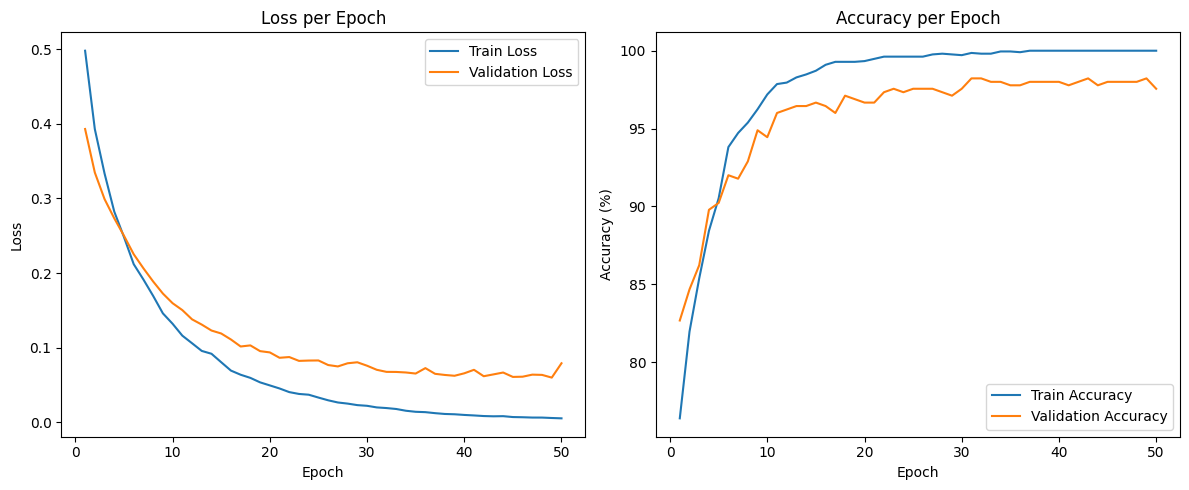

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(range(1, epochs + 1), train_losses, label="Train Loss")
axs[0].plot(range(1, epochs + 1), val_losses, label="Validation Loss")
axs[0].set_title("Loss per Epoch")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()

axs[1].plot(range(1, epochs + 1), train_accuracies, label="Train Accuracy")
axs[1].plot(range(1, epochs + 1), val_accuracies, label="Validation Accuracy")
axs[1].set_title("Accuracy per Epoch")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy (%)")
axs[1].legend()

plt.tight_layout()
plt.show()

## Evaluate on Test Set

In [14]:
all_labels = []
all_predictions = []

model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        predicted = (outputs > 0.5).float() 
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

print(f"Test Loss: {test_loss / len(test_loader):.4f}")
print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Loss: 0.1868
Test Accuracy: 95.56%


## Generate a confusion matrix to better visualize our model

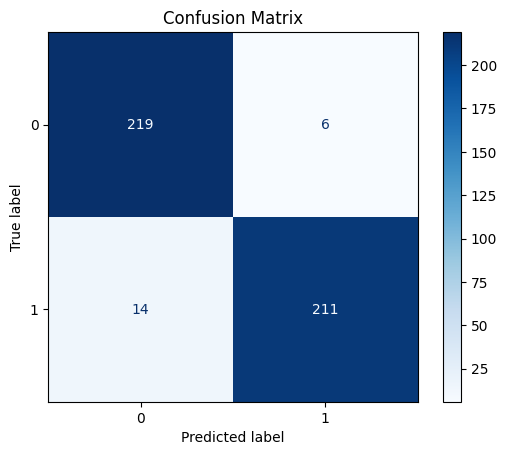

In [15]:
cm = confusion_matrix(all_labels, all_predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

Our CNN appears to perform very well. It achieves a 96.44% accuracy on our testing set and our of 450 samples, only predicted 8 of them incorrectly.

# Masked Autoencoder (MAE) + Anomaly Detection Classification